In [1]:
from dotenv import load_dotenv

load_dotenv()

import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

/home/ubuntu/mech-interp-color-steering/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = False

TypeError: str expected, not bool

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"

# MODEL_NAME = "Qwen/Qwen3-4B"
MODEL_NAME = "meta-llama/Llama-2-13b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, device_map=device, token=os.getenv("HUGGINGFACE_API_KEY")
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map=device, token=os.getenv("HUGGINGFACE_API_KEY")
)
model.half().cuda()
model.eval()

Loading checkpoint shards: 100%|██████████| 3/3 [00:12<00:00,  4.31s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((5120,), eps=1e-05)
    (rotary_e

In [4]:
from probe_dataset import ReadingProbeDataset

dataset = ReadingProbeDataset(
    directory="data/gemini/",
    model=model,
    tokenizer=tokenizer,
)

Loading data: 100%|██████████| 400/400 [02:27<00:00,  2.71it/s]


In [7]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
print(f"Train size: {train_size}, Test size: {test_size}")

Train size: 300, Test size: 100


In [8]:
import sklearn.model_selection

train_idx, val_idx = sklearn.model_selection.train_test_split(
    list(range(len(dataset))),
    test_size=test_size,
    train_size=train_size,
    random_state=12345,
    shuffle=True,
    stratify=dataset.labels,
)

print(f"Train idx: {train_idx}")
print(f"Val idx: {val_idx}")

Train idx: [1, 27, 103, 156, 223, 354, 51, 184, 83, 26, 49, 199, 87, 84, 85, 0, 372, 304, 96, 18, 268, 111, 155, 189, 72, 107, 125, 175, 46, 232, 295, 262, 220, 373, 65, 198, 378, 382, 91, 43, 299, 200, 392, 75, 141, 115, 177, 327, 266, 41, 50, 164, 322, 147, 263, 180, 119, 238, 309, 37, 186, 113, 353, 35, 7, 377, 291, 57, 355, 282, 21, 330, 347, 222, 89, 369, 302, 77, 293, 358, 207, 278, 254, 243, 134, 152, 396, 300, 245, 384, 168, 39, 17, 66, 114, 71, 260, 321, 99, 124, 176, 193, 181, 334, 93, 3, 36, 94, 110, 216, 80, 218, 389, 88, 341, 32, 242, 11, 159, 380, 101, 45, 82, 209, 120, 170, 211, 73, 194, 78, 365, 314, 395, 118, 153, 157, 15, 191, 361, 292, 219, 187, 326, 311, 201, 270, 8, 349, 246, 148, 5, 24, 249, 379, 259, 196, 179, 56, 236, 267, 67, 59, 121, 356, 371, 202, 132, 52, 367, 40, 108, 352, 375, 63, 190, 33, 128, 172, 9, 98, 329, 149, 203, 151, 2, 381, 362, 344, 53, 160, 226, 31, 143, 333, 173, 285, 214, 224, 61, 215, 272, 331, 205, 30, 44, 357, 86, 208, 25, 235, 137, 28, 14

In [9]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, val_idx)

In [10]:
from torch.utils.data.dataloader import DataLoader

sampler = None
train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    sampler=sampler,
    pin_memory=True,
    batch_size=200,
    num_workers=1,
)
test_loader = DataLoader(
    test_dataset, shuffle=False, pin_memory=True, batch_size=400, num_workers=1
)

In [11]:
import torch.nn as nn

loss_func = nn.BCELoss()

In [12]:
accuracy_dict = {}

dict_name = "yellow_reading_probe"

accuracy_dict[dict_name] = []
accuracy_dict[dict_name + "_final"] = []
accuracy_dict[dict_name + "_train"] = []

Training layers:   0%|          | 0/41 [00:00<?, ?it/s]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 0----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.6931 (0.386 sec) Accuracy: 0.500



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.6931,  Accuracy: 0.510



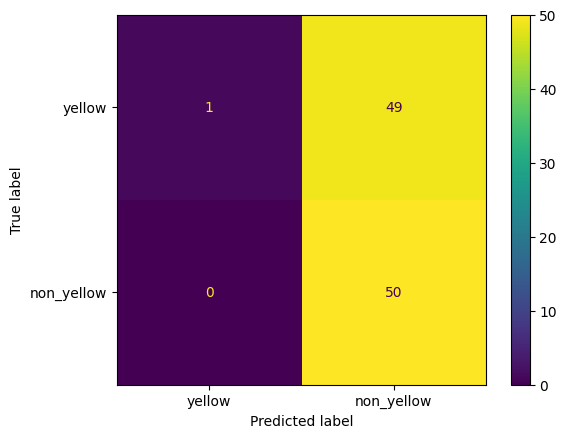

Training layers:   2%|▏         | 1/41 [00:31<20:46, 31.15s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 1----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.2255 (0.360 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.8635,  Accuracy: 0.500



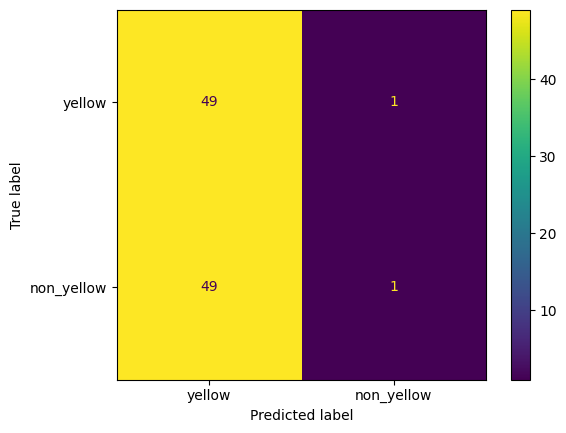

Training layers:   5%|▍         | 2/41 [01:01<19:47, 30.46s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 2----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 48.9346 (0.364 sec) Accuracy: 0.507



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0139,  Accuracy: 0.500



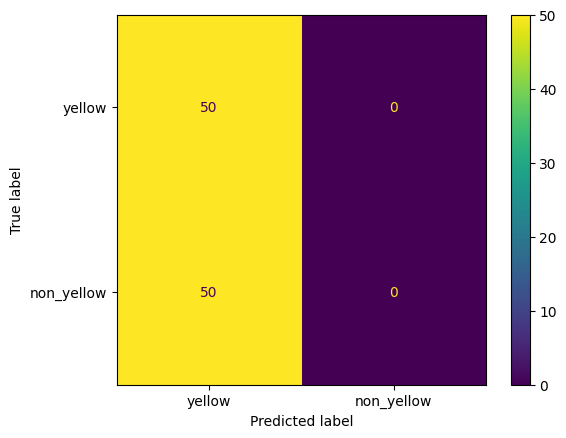

Training layers:   7%|▋         | 3/41 [01:30<19:05, 30.15s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 3----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.1364 (0.336 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0139,  Accuracy: 0.500



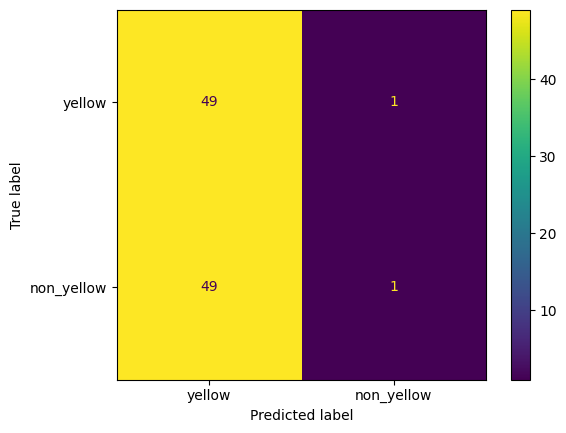

Training layers:  10%|▉         | 4/41 [02:01<18:34, 30.13s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 4----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 33.1651 (0.396 sec) Accuracy: 0.507



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 33.4784,  Accuracy: 0.500



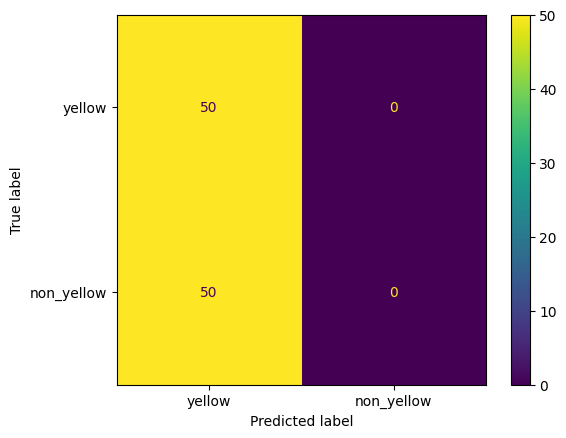

Training layers:  12%|█▏        | 5/41 [02:30<18:00, 30.00s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 5----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.8839 (0.375 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9072,  Accuracy: 0.500



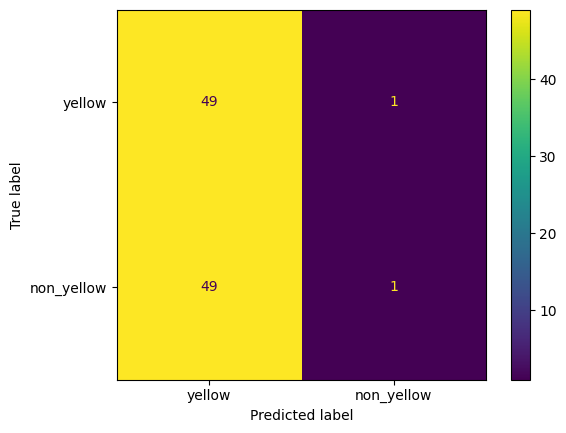

Training layers:  15%|█▍        | 6/41 [03:00<17:31, 30.04s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 6----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 25.1437 (0.343 sec) Accuracy: 0.503



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9629,  Accuracy: 0.500



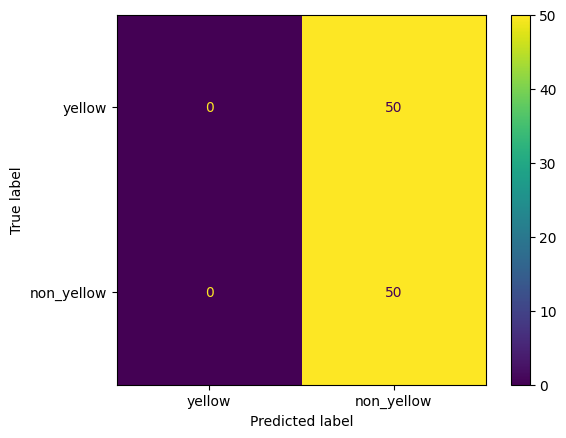

Training layers:  17%|█▋        | 7/41 [03:30<16:57, 29.93s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 7----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.7744 (0.391 sec) Accuracy: 0.567



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.8744,  Accuracy: 0.570



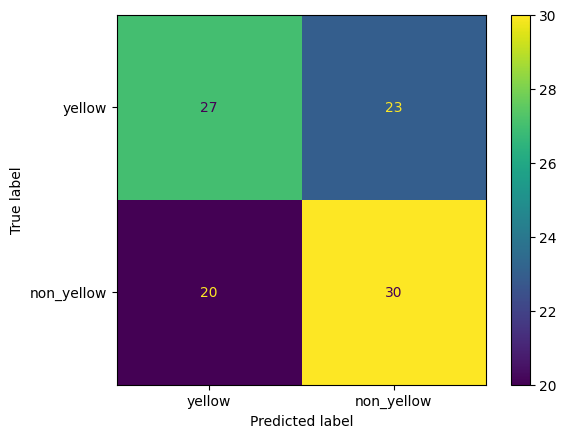

Training layers:  20%|█▉        | 8/41 [04:00<16:27, 29.93s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 8----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.8079 (0.368 sec) Accuracy: 0.563



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.9460,  Accuracy: 0.560



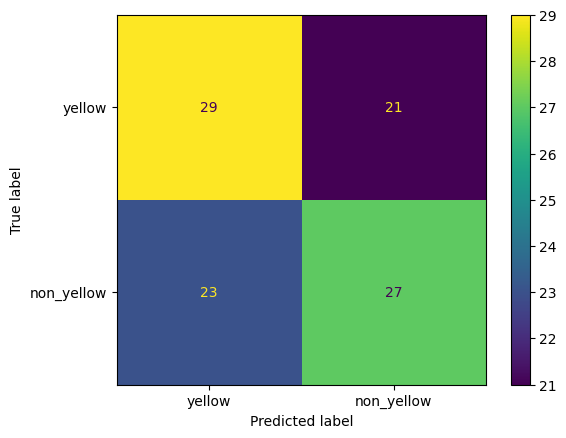

Training layers:  22%|██▏       | 9/41 [04:30<15:58, 29.96s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 9----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.3800 (0.358 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0140,  Accuracy: 0.500



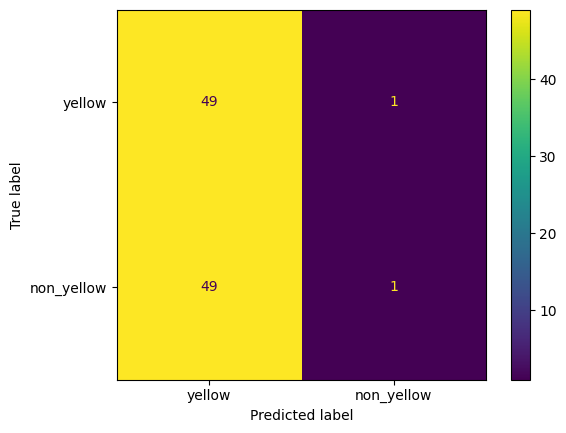

Training layers:  24%|██▍       | 10/41 [05:00<15:30, 30.01s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 10----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.8387 (0.364 sec) Accuracy: 0.560



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.9079,  Accuracy: 0.590



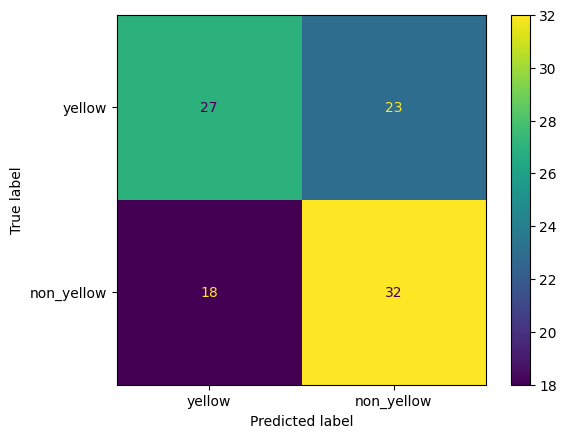

Training layers:  27%|██▋       | 11/41 [05:31<15:03, 30.11s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 11----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.2552 (0.384 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0163,  Accuracy: 0.500



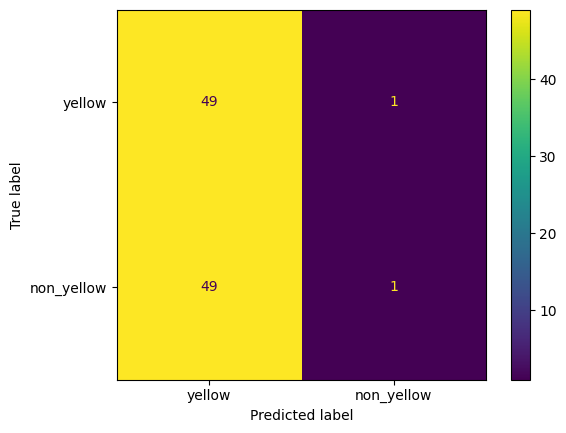

Training layers:  29%|██▉       | 12/41 [06:00<14:28, 29.94s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 12----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.8820 (0.361 sec) Accuracy: 0.513



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 25.0428,  Accuracy: 0.500



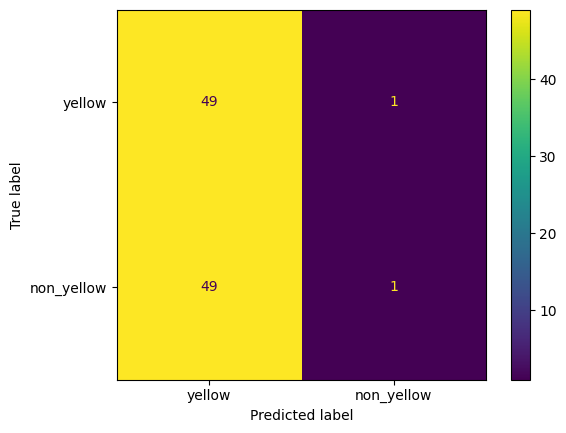

Training layers:  32%|███▏      | 13/41 [06:30<14:01, 30.06s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 13----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 25.0035 (0.394 sec) Accuracy: 0.503



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9076,  Accuracy: 0.500



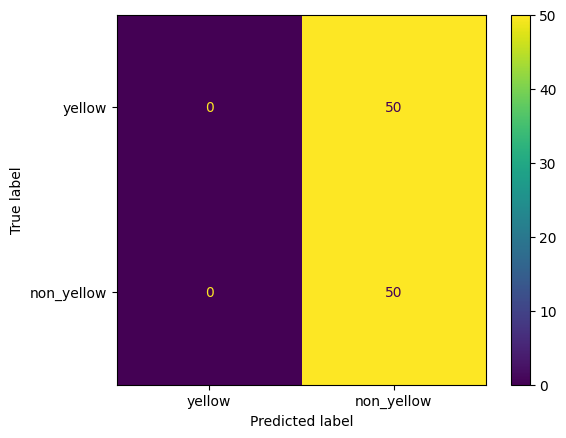

Training layers:  34%|███▍      | 14/41 [07:01<13:34, 30.15s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 14----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.1144 (0.386 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9284,  Accuracy: 0.500



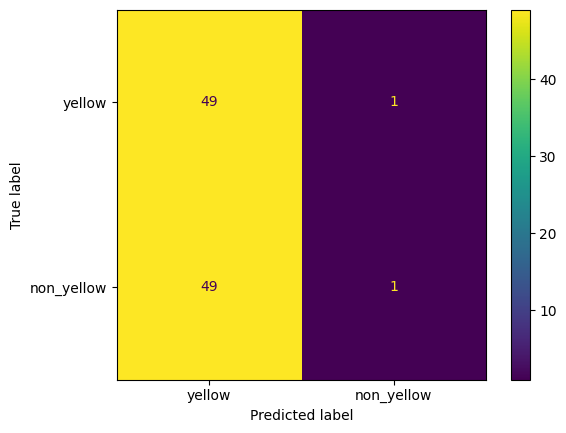

Training layers:  37%|███▋      | 15/41 [07:31<13:03, 30.12s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 15----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.8022 (0.401 sec) Accuracy: 0.577



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.8633,  Accuracy: 0.580



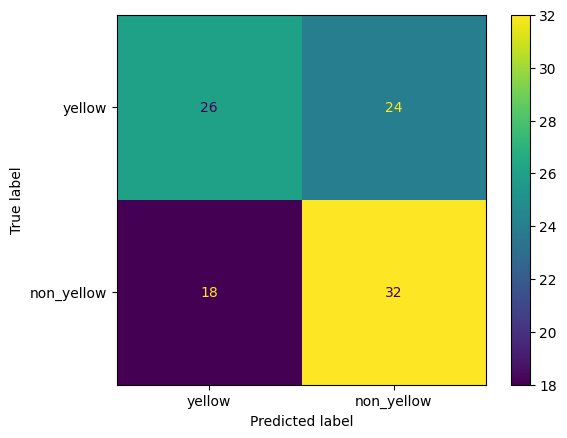

Training layers:  39%|███▉      | 16/41 [08:02<12:38, 30.32s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 16----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.5070 (0.388 sec) Accuracy: 0.507



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9529,  Accuracy: 0.500



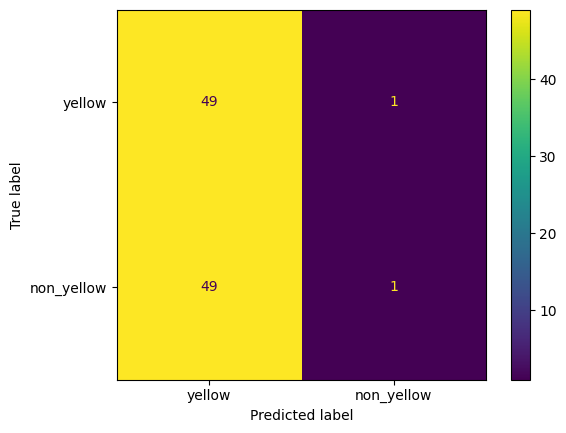

Training layers:  41%|████▏     | 17/41 [08:33<12:17, 30.72s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 17----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.2681 (0.379 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9607,  Accuracy: 0.500



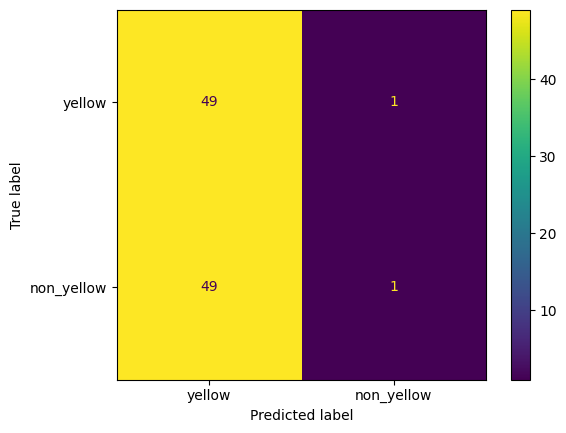

Training layers:  44%|████▍     | 18/41 [09:04<11:46, 30.71s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 18----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.0036 (0.387 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0098,  Accuracy: 0.510



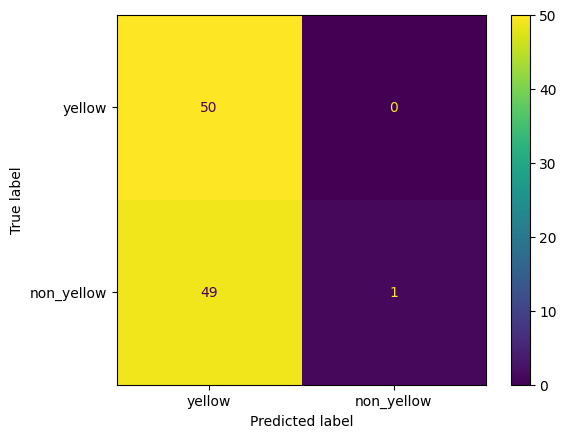

Training layers:  46%|████▋     | 19/41 [09:35<11:15, 30.72s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 19----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 25.3492 (0.378 sec) Accuracy: 0.507



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.8913,  Accuracy: 0.500



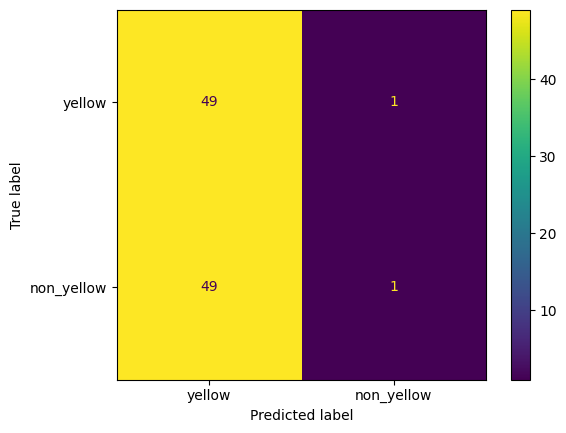

Training layers:  49%|████▉     | 20/41 [10:06<10:50, 30.98s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 20----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 25.3608 (0.390 sec) Accuracy: 0.503



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.8650,  Accuracy: 0.500



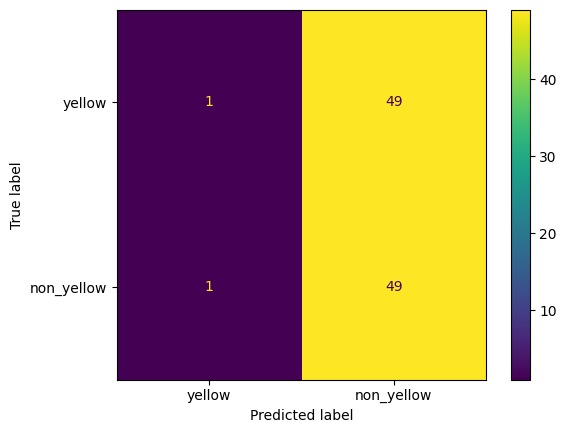

Training layers:  51%|█████     | 21/41 [10:36<10:14, 30.74s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 21----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.2515 (0.417 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0116,  Accuracy: 0.510



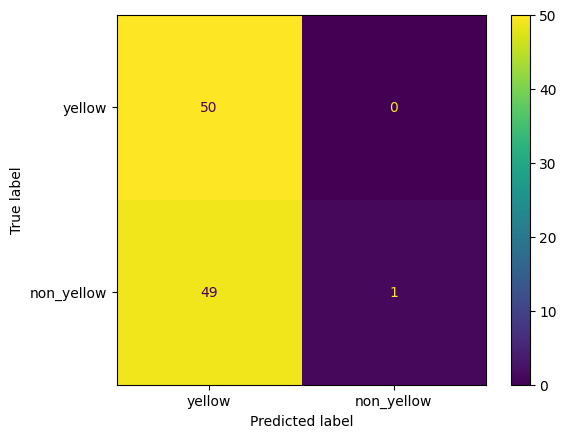

Training layers:  54%|█████▎    | 22/41 [11:08<09:46, 30.88s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 22----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 51.0006 (0.379 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0183,  Accuracy: 0.500



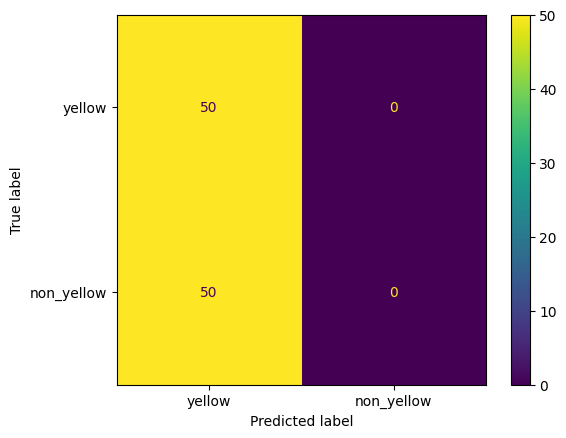

Training layers:  56%|█████▌    | 23/41 [11:38<09:13, 30.75s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 23----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.8221 (0.371 sec) Accuracy: 0.503



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9880,  Accuracy: 0.510



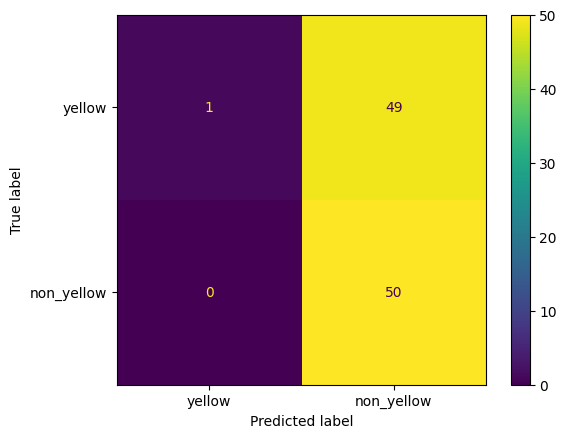

Training layers:  59%|█████▊    | 24/41 [12:09<08:43, 30.78s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 24----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.7479 (0.352 sec) Accuracy: 0.573



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.8305,  Accuracy: 0.590



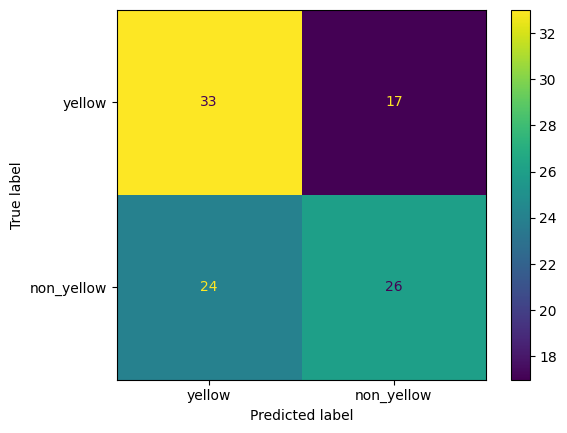

Training layers:  61%|██████    | 25/41 [12:39<08:09, 30.57s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 25----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 48.9904 (0.387 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 48.5146,  Accuracy: 0.500



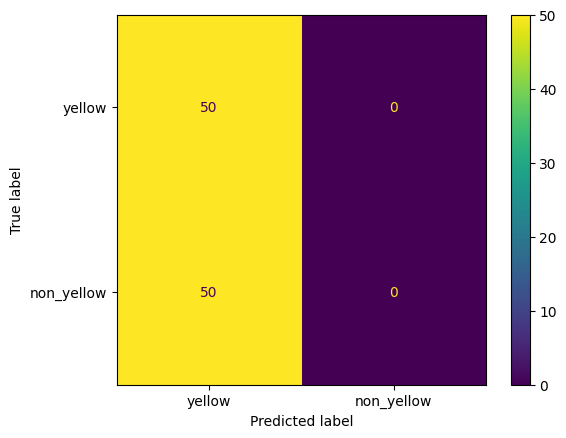

Training layers:  63%|██████▎   | 26/41 [13:10<07:39, 30.66s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 26----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.2507 (0.380 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0105,  Accuracy: 0.510



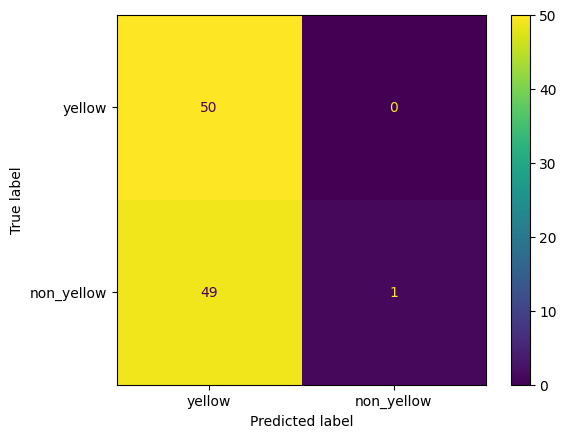

Training layers:  66%|██████▌   | 27/41 [13:41<07:11, 30.79s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 27----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.0005 (0.359 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0225,  Accuracy: 0.500



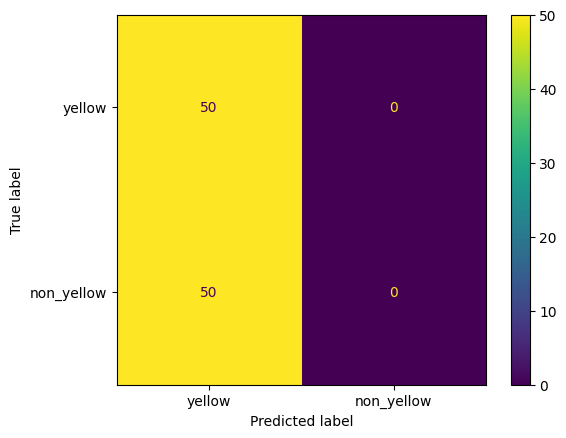

Training layers:  68%|██████▊   | 28/41 [14:11<06:38, 30.65s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 28----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 48.2567 (0.398 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0194,  Accuracy: 0.490



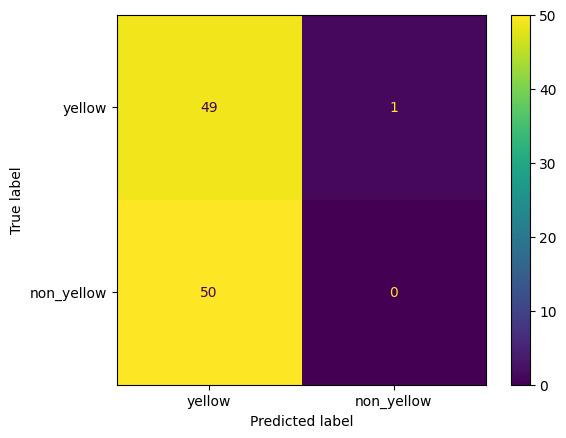

Training layers:  71%|███████   | 29/41 [14:42<06:08, 30.73s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 29----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.5002 (0.378 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0151,  Accuracy: 0.510



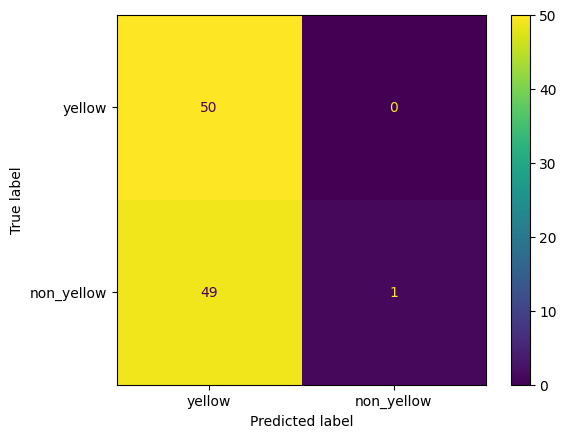

Training layers:  73%|███████▎  | 30/41 [15:13<05:38, 30.73s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 30----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 1.8179 (0.377 sec) Accuracy: 0.503



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.9199,  Accuracy: 0.550



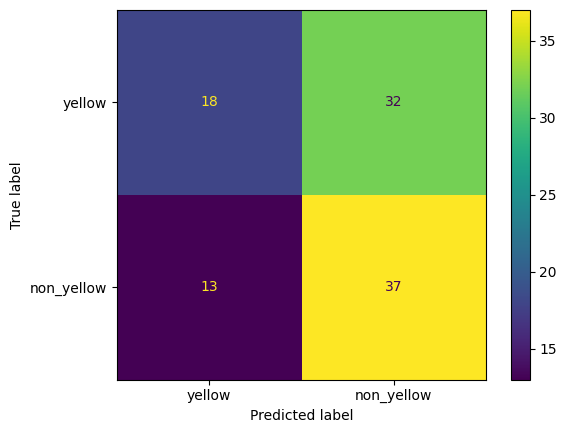

Training layers:  76%|███████▌  | 31/41 [15:44<05:07, 30.71s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 31----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.3752 (0.388 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0166,  Accuracy: 0.500



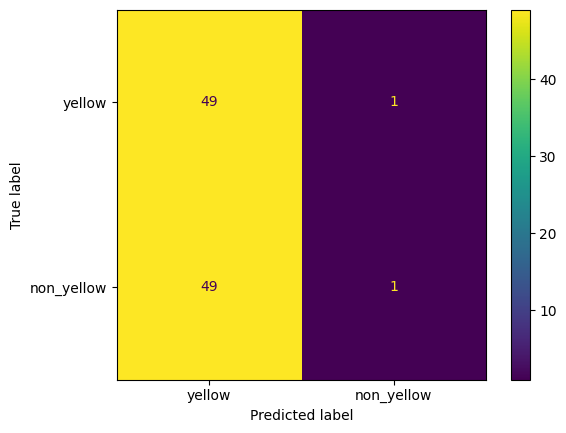

Training layers:  78%|███████▊  | 32/41 [16:14<04:34, 30.52s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 32----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.0005 (0.414 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0098,  Accuracy: 0.490



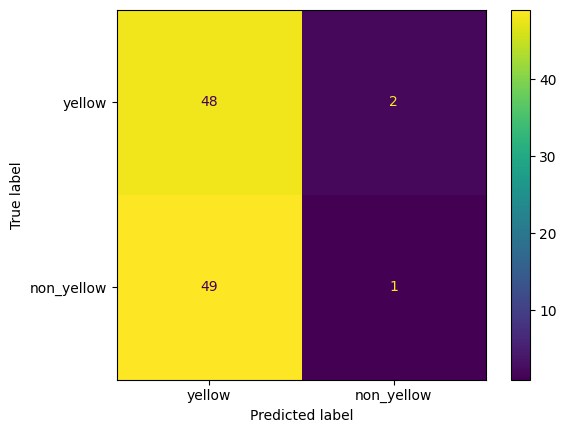

Training layers:  80%|████████  | 33/41 [16:44<04:04, 30.59s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 33----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.2501 (0.387 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0200,  Accuracy: 0.500



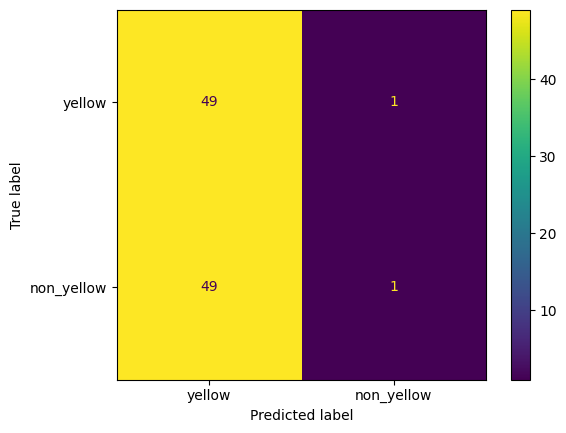

Training layers:  83%|████████▎ | 34/41 [17:15<03:34, 30.71s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 34----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 48.2501 (0.380 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0156,  Accuracy: 0.500



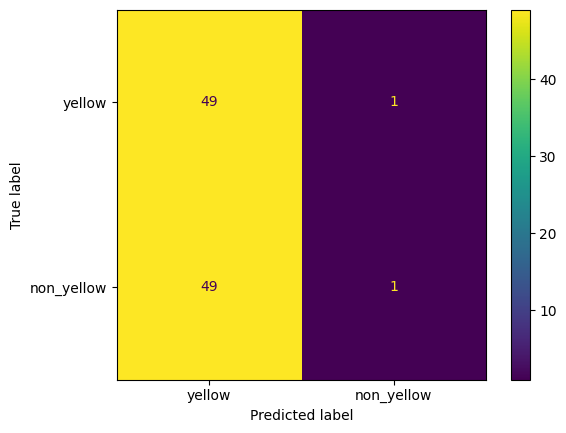

Training layers:  85%|████████▌ | 35/41 [17:46<03:03, 30.63s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 35----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.2502 (0.393 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0316,  Accuracy: 0.490



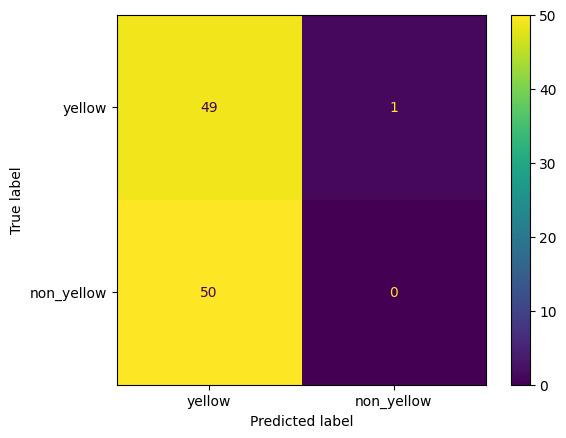

Training layers:  88%|████████▊ | 36/41 [18:17<02:34, 30.83s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 36----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.5420 (0.416 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 25.0227,  Accuracy: 0.500



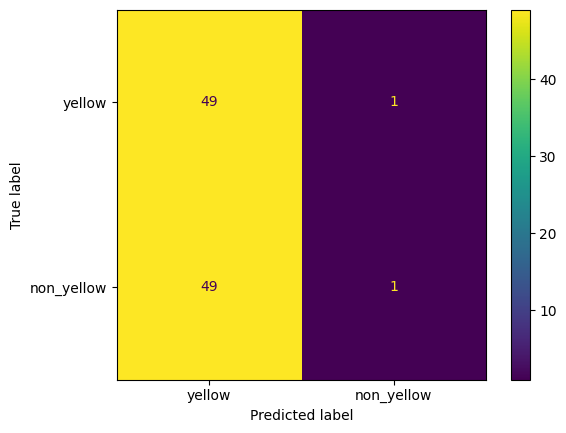

Training layers:  90%|█████████ | 37/41 [18:50<02:05, 31.38s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 37----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 49.2501 (0.360 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 49.0182,  Accuracy: 0.490



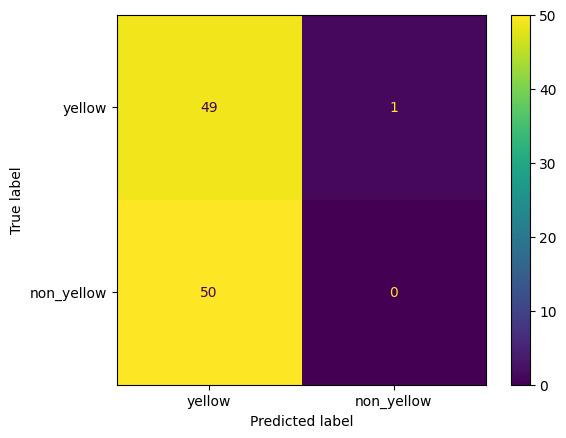

Training layers:  93%|█████████▎| 38/41 [19:21<01:34, 31.43s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 38----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 24.9975 (0.372 sec) Accuracy: 0.503



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9230,  Accuracy: 0.500



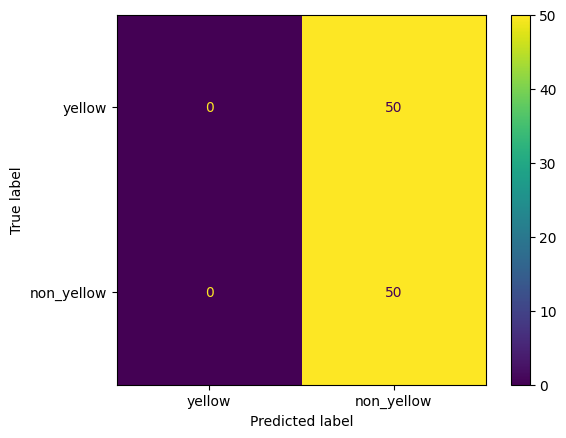

Training layers:  95%|█████████▌| 39/41 [19:52<01:02, 31.27s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 39----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 25.1077 (0.401 sec) Accuracy: 0.503



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 24.9827,  Accuracy: 0.500



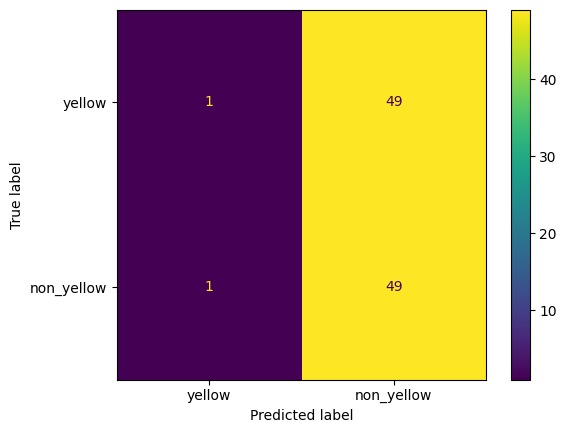

Training layers:  98%|█████████▊| 40/41 [20:22<00:30, 30.83s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 40----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.6818 (0.409 sec) Accuracy: 0.510



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.6936,  Accuracy: 0.500



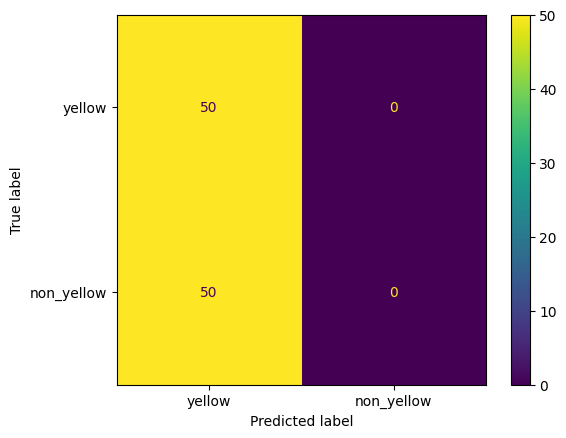

Training layers: 100%|██████████| 41/41 [20:53<00:00, 30.57s/it]


In [13]:
import pickle
from tqdm.auto import tqdm
from probes import LinearProbeClassification, TrainerConfig
from train_test_utils import train, test
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

one_hot = True

label_to_id = {
    "yellow": 1,
    "non_yellow": 0,
}

uncertainty = False

accs = []
final_accs = []
train_accs = []
for i in tqdm(range(0, 41), desc="Training layers"):
    trainer_config = TrainerConfig()
    probe = LinearProbeClassification(
        probe_class=len(label_to_id.keys()),
        device="cuda",
        input_dim=5120,
        logistic=True,
    )
    optimizer, scheduler = probe.configure_optimizers(trainer_config)
    best_acc = 0
    max_epoch = 50
    verbosity = False
    layer_num = i
    print("-" * 40 + f"Layer {layer_num}" + "-" * 40)
    for epoch in range(1, max_epoch + 1):
        if epoch == max_epoch:
            verbosity = True
        # Get the train results from training of each epoch
        if uncertainty:
            train_results = train(
                probe,
                device,
                train_loader,
                optimizer,
                epoch,
                loss_func=loss_func,
                verbose_interval=None,
                verbose=verbosity,
                layer_num=layer_num,
                return_raw_outputs=True,
                epoch_num=epoch,
                num_classes=len(label_to_id.keys()),
            )
            test_results = test(
                probe,
                device,
                test_loader,
                loss_func=loss_func,
                return_raw_outputs=True,
                verbose=verbosity,
                layer_num=layer_num,
                scheduler=scheduler,
                epoch_num=epoch,
                num_classes=len(label_to_id.keys()),
            )
        else:
            train_results = train(
                probe,
                device,
                train_loader,
                optimizer,
                epoch,
                loss_func=loss_func,
                verbose_interval=None,
                verbose=verbosity,
                layer_num=layer_num,
                return_raw_outputs=True,
                one_hot=one_hot,
                num_classes=len(label_to_id.keys()),
            )
            test_results = test(
                probe,
                device,
                test_loader,
                loss_func=loss_func,
                return_raw_outputs=True,
                verbose=verbosity,
                layer_num=layer_num,
                scheduler=scheduler,
                one_hot=one_hot,
                num_classes=len(label_to_id.keys()),
            )

        if test_results[1] > best_acc:
            best_acc = test_results[1]
            torch.save(
                probe.state_dict(),
                f"probe_checkpoints/reading_probe/{dict_name}_probe_at_layer_{layer_num}.pth",
            )
    torch.save(
        probe.state_dict(),
        f"probe_checkpoints/reading_probe/{dict_name}_probe_at_layer_{layer_num}_final.pth",
    )

    accs.append(best_acc)
    final_accs.append(test_results[1])
    train_accs.append(train_results[1])
    cm = confusion_matrix(test_results[3], test_results[2])
    cm_display = ConfusionMatrixDisplay(
        cm, display_labels=label_to_id.keys()
    ).plot()
    plt.show()

    accuracy_dict[dict_name].append(accs)
    accuracy_dict[dict_name + "_final"].append(final_accs)
    accuracy_dict[dict_name + "_train"].append(train_accs)

    with open(
        "probe_checkpoints/reading_probe_experiment.pkl", "wb"
    ) as outfile:
        pickle.dump(accuracy_dict, outfile)
# del dataset, train_dataset, test_dataset, train_loader, test_loader
torch.cuda.empty_cache()

(0.2, 0.8)

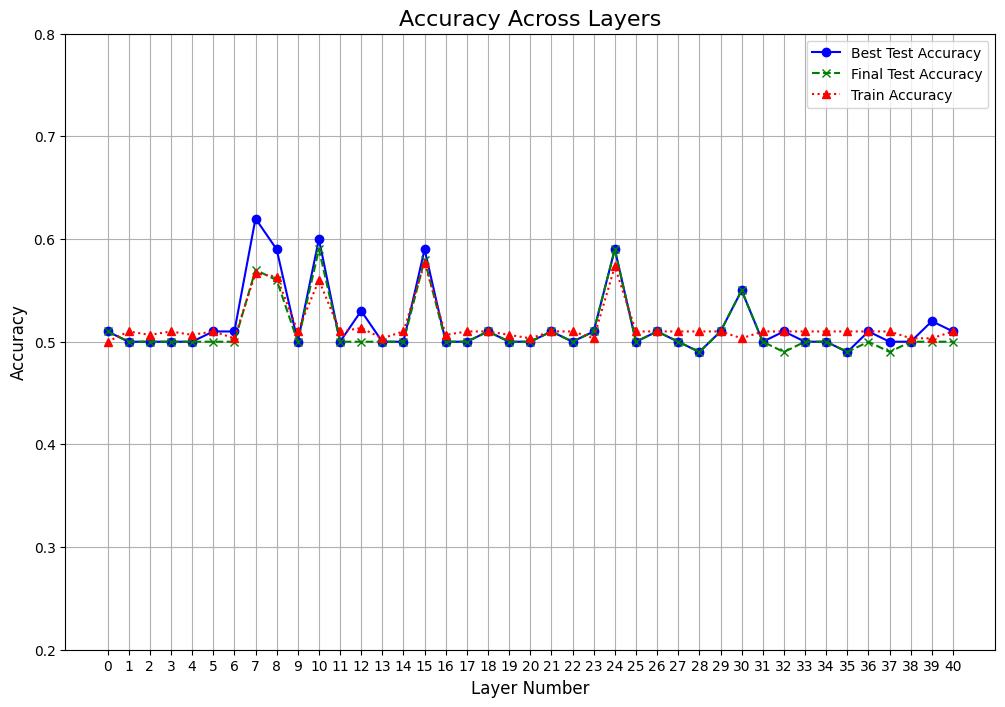

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the x-axis values (layer numbers)
layers = np.arange(len(accs))

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(
    layers,
    accs,
    label="Best Test Accuracy",
    marker="o",
    linestyle="-",
    color="b",
)

# Plot final_accs
plt.plot(
    layers,
    final_accs,
    label="Final Test Accuracy",
    marker="x",
    linestyle="--",
    color="g",
)

# Plot train_accs
plt.plot(
    layers,
    train_accs,
    label="Train Accuracy",
    marker="^",
    linestyle=":",
    color="r",
)

# Add labels and title
plt.title("Accuracy Across Layers", fontsize=16)
plt.xlabel("Layer Number", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(layers)
plt.grid(True)
plt.legend(fontsize=10)
plt.ylim(0.2, 0.8)